<a href="https://colab.research.google.com/github/lonespear/MA206/blob/main/challenger_rmd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("DAAG")
library(tidyverse)
library(DAAG)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘deldir’, ‘RcppEigen’, ‘png’, ‘jpeg’, ‘interp’, ‘rbibutils’, ‘latticeExtra’, ‘Rdpack’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Challenger Disaster: Turning Data into Information

On January 28, 2986, disaster struck at NASA and the country when the Challenger space shuttle exploded 73 seconds into its flight from the Kennedy Space Center, breaking apart 46,000 feet above the Atlantic Ocean.

https://www.youtube.com/watch?v=yibNEcn-4yQ

The explosion was caused by a design flaw in the rubber O-ring seals on the solid rocket boosters. The seals were intended to prevent hot exhaust gases from escaping, but they were sensitive to low temperatures and became brittle in the cold weather of the launch.

So that is the what, but what truly is the why? Why were authorities and experts not keenly aware of the sensitivity of the O-rings to temperature?

<div style="text-align: center;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/3/3f/Challenger_flight_51-l_crew.jpg" alt="Challenger Crew" width="600">
</div>


## The Data

Since this was a historic event, many analyses have been conducted researching the mechanical failure, and the R package DAAG (Data Analysis and Graphics) has the specific o-ring dataset comparing material properties with temperature. Lets investigate further looking at only the data prior to the Challenger disaster:

In [ ]:
data <- orings %>% filter(Temperature != min(Temperature))
summary(data)

  Temperature       Erosion           Blowby            Total       
 Min.   :57.00   Min.   :0.0000   Min.   :0.00000   Min.   :0.0000  
 1st Qu.:67.00   1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.0000  
 Median :70.00   Median :0.0000   Median :0.00000   Median :0.0000  
 Mean   :70.32   Mean   :0.2273   Mean   :0.09091   Mean   :0.2727  
 3rd Qu.:75.00   3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:0.7500  
 Max.   :81.00   Max.   :1.0000   Max.   :2.00000   Max.   :1.0000  

We have 22 observations (n=22), with four covariates (variables) per observation: Temperature, Erosion, Blowby, and Total. (Erosion means the oring was damaged, blowby means the o-ring lost its sealing ability and fuel was leaking past the junction/valve, total is the sum of both erosion and blowby)

Lets look at a visualization of Total vs Temperature!

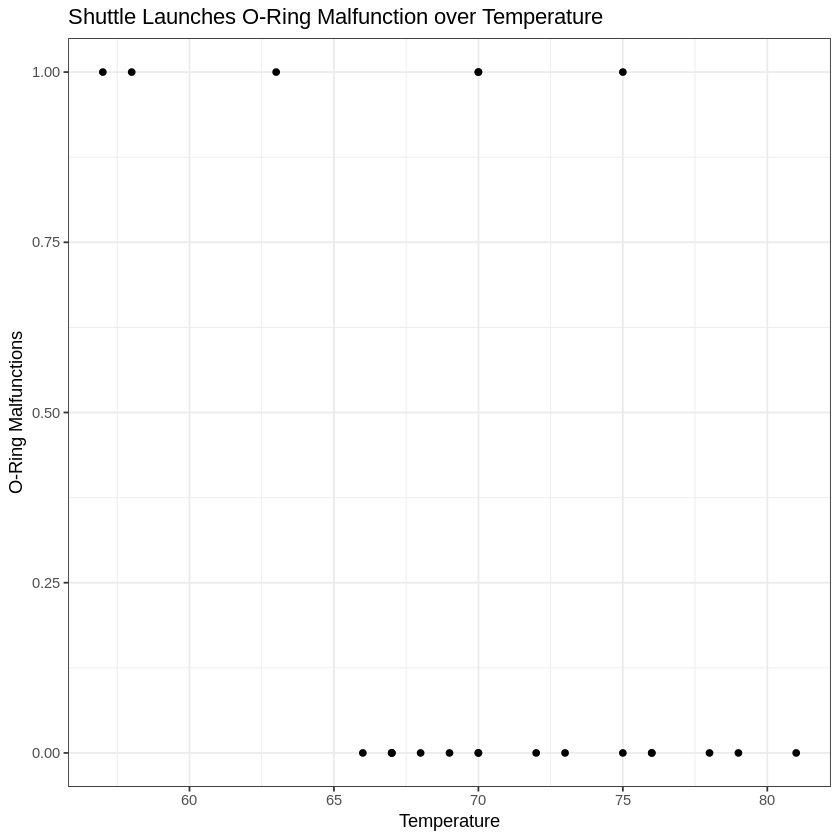

In [ ]:
ggplot(data, aes(x=Temperature, y=Total)) + geom_point() +
  theme_bw() +
  labs(x="Temperature", y="O-Ring Malfunctions", title="Shuttle Launches O-Ring Malfunction over Temperature")

We created a scatter plot since both Temperature and Total are quantitative variables, however since there are only two values for Total (0 or 1), we can treat it as a categorical variable and look at the Temperature for when no failures occured, and when just one occured. This is demonstrated with the two box plots below.

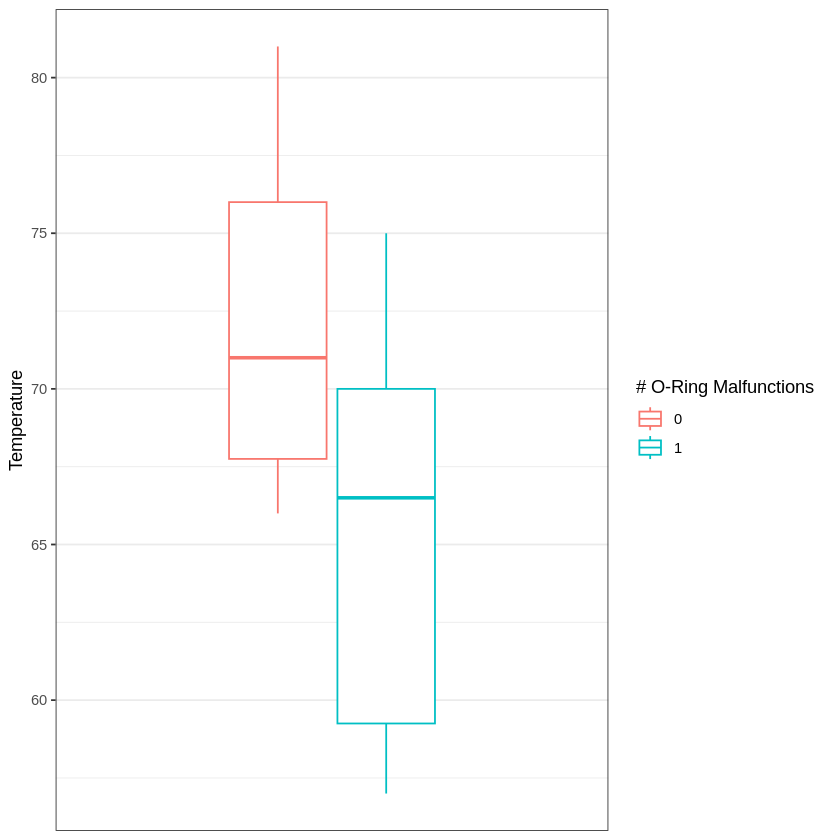

In [ ]:
ggplot(data) +
  geom_boxplot(aes(y = Temperature, group = as.factor(Total), color = as.factor(Total))) +
  scale_x_discrete() +  # Customize x-axis labels
  theme_bw() +
  labs(color="# O-Ring Malfunctions")

With only 22 observations, it may be hard to nail down solid trends, however we can always form intial opinions about them regardless! I notice that no failures occur when the temperature at launch is over 75$^\circ$, while there is at least one o-ring malfunction when the temperature is below 67$^\circ$.

Lets add a sigmoid curve (a function used when we have a categorical response variable) to model our data:


Formula: Total ~ SSlogis(Temperature, Asym, xmid, scal)

Parameters:
       Estimate Std. Error t value Pr(>|t|)   
Asym     1.0000     0.2810   3.559  0.00209 **
xmid    64.5980 67095.6444   0.001  0.99924   
scal    -0.1079  5150.6148   0.000  0.99998   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3974 on 19 degrees of freedom

Number of iterations to convergence: 0 
Achieved convergence tolerance: 1.326e-06


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


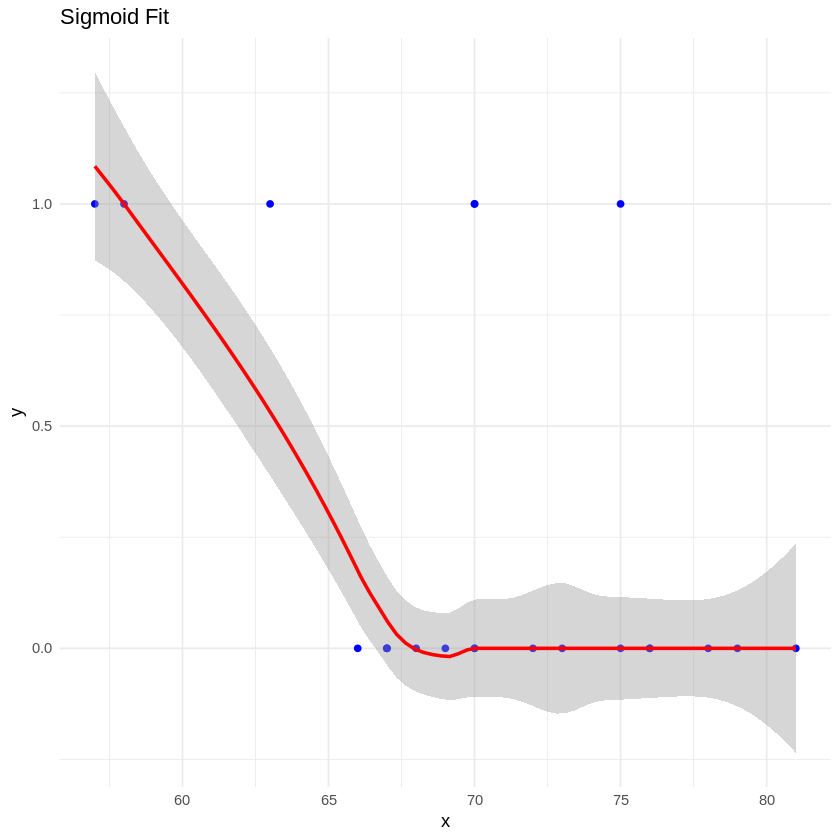

In [ ]:
# Define the sigmoid function
sigmoid <- function(x, L, k, x0) {
  L / (1 + exp(-k * (x - x0)))
}

# Fit the model using nls (nonlinear least squares)
fit <- nls(Total ~ SSlogis(Temperature, Asym, xmid, scal), data = data)

# View summary of the fit
summary(fit)

# Predicted values
data$y_pred <- predict(fit)

# Plot the data and fitted curve
library(ggplot2)
ggplot(data, aes(x = Temperature)) +
  geom_point(aes(y = Total), color = "blue") +  # Original data points
  geom_smooth(aes(y = y_pred), color = "red") +  # Fitted sigmoid curve
  theme_minimal() +
  labs(title = "Sigmoid Fit", x = "x", y = "y")

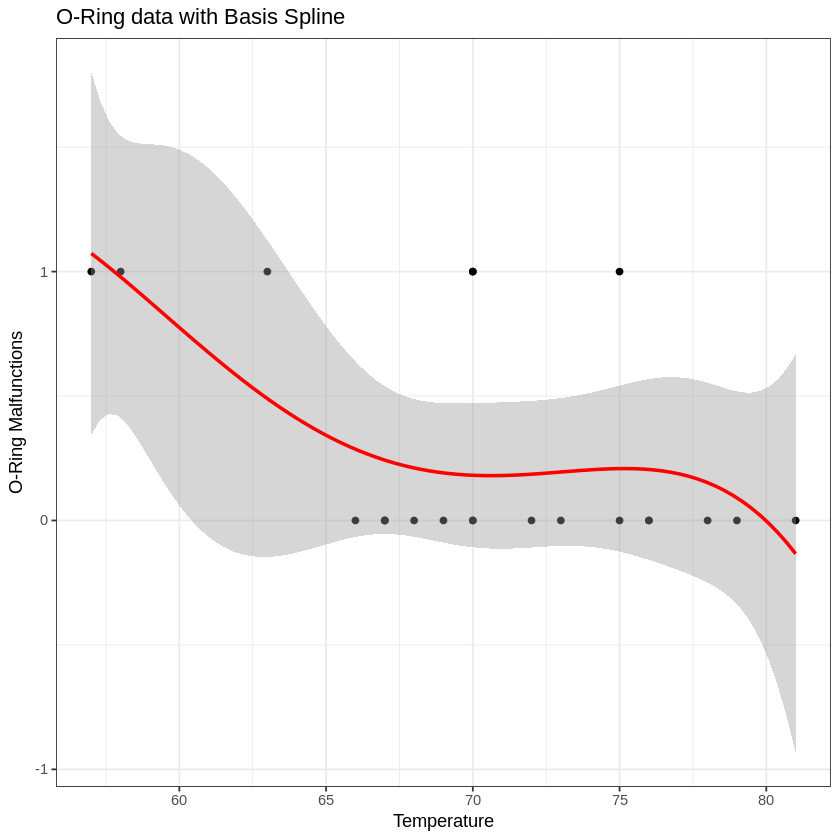

In [ ]:
ggplot(data, aes(x=Temperature, y=Total)) + geom_point() +
  theme_bw() + geom_smooth(method = "lm", formula = y ~ splines::bs(x, degree = 4), color = "red", linewidth = 1) +
  labs(x="Temperature", y="O-Ring Malfunctions", title="O-Ring data with Basis Spline")

So what was the forecasted temperature the day of the Challenger's launch? **26 to 29 degrees**. Lets add the forecast to the plot.

In [ ]:
ggplot(orings, aes(x=Temperature, y=Total)) + geom_point() +
  theme_bw() + geom_smooth(method = "lm", formula = y ~ splines::bs(x, degree = 4), color = "red", linewidth = 1) +
  labs(x="Temperature", y="O-Ring Malfunctions", title="O-Ring data with Basis Spline") +
  annotate("rect", xmin = 26, xmax = 29,  ymin=0, ymax=6,
             alpha = 0.3, fill = "red") +
    # Add text
    annotate("text", x = 30, y = 3,
             label = "Forecast \n temperature \n 26 to 29")

The actual temperature inside the shuttle at the point of the o-rings was 53 degrees.

The space shuttle had two O-rings per fuel joint on each of its solid rocket boosters (SRBs), creating a redundant sealing system to prevent hot combustion gases from escaping at the joints where the booster segments were connected; essentially, each field joint had two O-rings, a primary and a secondary one.

The explosion was caused from both a primary and secondary o-ring failure in one of the fuel joints.

Did anyone know about this? Engineers in the room? Yes! One person, Roger Boisjoly had determined that extreme cold would adversely affect the rubber O-rings that formed an airtight seal between segments of the solid rocket boosters. Low temperatures would harden the rubber, he said, making it less flexible. This condition could allow hot combustion gases to escape through the damaged seals, creating a potentially dangerous situation.

Boisjoly was so concerned that, six months before the Challenger launch, he sent a memo to the company’s vice president of engineering to ensure that management was “fully aware of the seriousness of the current O-ring erosion problem,” the result of which “would be a catastrophe of the highest order — the loss of human life.”

<p></p><center><img src="https://www.nasa.gov/wp-content/uploads/static/history/rogersrep/v4p692.jpg" alt="Interoffice Memo, Morton Thiokol, Inc.; From: R. Boisjoly to R.K. Lund. Subject: SRM O-Ring Erosion/Potential Failure Criticality. Dated: 31 July 1985. - continued." width="510" height="663" x-sas-useimagewidth x-sas-useimageheight align="bottom"></center>

Why was no one convinced? Potentially from how they were visualizing the information. The below figure is how the above information had been displayed previously.

<center>
<a href="https://www.researchgate.net/figure/History-of-o-ring-damage-in-field-joints-cont-Morton-Thiokol-Inc_fig2_314260269"><img src="https://www.researchgate.net/publication/314260269/figure/fig2/AS:961319222140945@1606207771767/History-of-o-ring-damage-in-field-joints-cont-Morton-Thiokol-Inc.gif" alt="History of o-ring damage in field joints (cont), Morton Thiokol, Inc."/></a></center>
